# Download and import all the necessary libraries

In [93]:
!pip install datasets torch contractions textblob kaleido
import pandas as pd
import re, string, unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

# Load HuggingFace datasets
from datasets import load_dataset

# Ensure you have the required NLTK resources
import nltk

# Download the Punkt tokenizer models.
# Punkt is a pre-trained tokenizer that divides text into sentences and words.
# This model is useful for tasks such as sentence splitting and word tokenization.
nltk.download('punkt')

# Download a set of common stopwords.
# Stopwords are common words (like "and", "the", "is") that are often
# filtered out in text processing because they are too frequent to
# provide meaningful information. This resource helps with removing or ignoring
# these words during text analysis.
nltk.download('stopwords')

# Download the WordNet lexical database.
# WordNet is a large lexical database of English that groups words into sets of
# synonyms (synsets) and provides various relations between them.
# It is used for tasks like word sense disambiguation, synonyms and
# antonyms finding, and semantic analysis.
nltk.download('wordnet')

# Download the Average Perceptron Tagger for POS Tagging
nltk.download('averaged_perceptron_tagger')

# Download the Maximum Entropy Named Entity Chunker to identify and classify
# named entities in text, such as names of people, organizations, or locations.
nltk.download('maxent_ne_chunker')

# Download a corpus of words that can be used as a reference for various
# NLP tasks, such as checking if a word exists or finding synonyms.
nltk.download('words')

# Import WordCloud to visualize text data
from wordcloud import WordCloud

# Visualization plots library
import matplotlib.pyplot as plt

# Import displacy from spacy library.
# This is to visualize the processed text data post NER and POS Tagging.
import spacy
from spacy import displacy
from spacy.tokens import Span

# Import stopwords
from nltk.corpus import stopwords

# Import Tokenizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Import Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

# Visualize data in graphical formats
import matplotlib.pyplot as plt
import seaborn as sns

# To count frequencies of words
from textblob import TextBlob
from collections import Counter

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Exploration and Visualization of SQuAD dataset

## Extract the SQuAD dataset to Dataframe from JSON file

In [3]:
train_data = pd.read_json('train-v1.1.json')
val_data = pd.read_json('dev-v1.1.json')

## Convert the loaded data to a dataframe

In [6]:
def convert_json_to_df(squad_data):
    columns = ['context', 'question', 'answer', 'ans_start', 'ans_end']
    dataset = pd.DataFrame(columns=columns)
    i = 0
    for value in squad_data['data']:
        for data in value['paragraphs']:
            for qas in data['qas']:
                answer = qas['answers'][0]['text'] if qas['answers'] else "No answer available."
                answer_start = qas['answers'][0]['answer_start'] if qas['answers'] else -1

                dataset.loc[i] =[data['context'], qas['question'], answer, answer_start, 0]
                i += 1

    return dataset

In [7]:
train_df = convert_json_to_df(train_data)
val_df = convert_json_to_df(val_data)

## Clean Text for both Train and Validation dataframes

As part of cleaning the text, we performed the following steps:

- Converted the complete text to lower case to maintain consistency.
- The actually loaded JSON and the converted dataframes have newline`\n` and carriage returns `\r`. Removed them.
- Replaced multiple spaces with single space
- Stripped all the leading and trailing whitespaces

In [8]:
def clean_text(text):
    # Lowercase the text (since we're using an uncased model)
    text = text.lower()
    # Remove newline and carriage returns
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    return text


def clean_text_data(dataset: pd.DataFrame):
    dataset[['context', 'question', 'answer']] = dataset[['context', 'question', 'answer']].map(clean_text)

In [9]:
# Call the cleanData function for both train_df and val_df
clean_text_data(train_df)
clean_text_data(val_df)

## Save the Dataframes to CSV files

In [10]:
train_df.to_csv("squad_cleaned_train.csv", index=False)
val_df.to_csv("squad_cleaned_validation.csv", index=False)

print("CSV files have been created and saved")

CSV files have been created and saved


## As this is just the data exploration and preprocessing part, we can merge both the train and validation dataframes to a single dataframe

In [16]:
merged_squad_df = pd.concat([train_df, val_df])

merged_df_path = "squad_extracted_merged.csv"

# Save merged DataFrame to CSV file
merged_squad_df.to_csv(merged_df_path, index=False)

print(f"Merged dataframe has been saved to - {merged_df_path}")

Merged dataframe has been saved to - squad_extracted_merged.csv


# Explore and understand the data

In [20]:
# First 5 rows of the dataframe
merged_squad_df.head()

context  \
0  architecturally, the school has a catholic cha...   
1  architecturally, the school has a catholic cha...   
2  architecturally, the school has a catholic cha...   
3  architecturally, the school has a catholic cha...   
4  architecturally, the school has a catholic cha...   

                                            question  \
0  to whom did the virgin mary allegedly appear i...   
1  what is in front of the notre dame main building?   
2  the basilica of the sacred heart at notre dame...   
3                  what is the grotto at notre dame?   
4  what sits on top of the main building at notre...   

                                    answer  ans_start  ans_end  
0               saint bernadette soubirous        515        0  
1                a copper statue of christ        188        0  
2                        the main building        279        0  
3  a marian place of prayer and reflection        381        0  
4       a golden statue of the virgin mary         92        0

In [23]:
# Last 5 rows of the dataframe
merged_squad_df.tail()

context  \
10565  the pound-force has a metric counterpart, less...   
10566  the pound-force has a metric counterpart, less...   
10567  the pound-force has a metric counterpart, less...   
10568  the pound-force has a metric counterpart, less...   
10569  the pound-force has a metric counterpart, less...   

                                                question          answer  \
10565  what is the metric term less used than the new...  kilogram-force   
10566  what is the kilogram-force sometimes reffered ...        kilopond   
10567  what is a very seldom used unit of mass in the...            slug   
10568  what seldom used term of a unit of force equal...             kip   
10569  what is the seldom used force unit equal to on...          sthène   

       ans_start  ans_end  
10565         82        0  
10566        114        0  
10567        274        0  
10568        712        0  
10569        665        0

In [32]:
# Shape of the dataframe
merged_squad_df.shape

(98169, 5)

In [24]:
# Columns of the dataframe
merged_squad_df.columns

Index(['context', 'question', 'answer', 'ans_start', 'ans_end'], dtype='object')

In [27]:
# Access the first row for sample view of the data
first_row = merged_squad_df.iloc[20]

# Print each value separately
print(f"Context: {first_row['context']}\n")
print(f"Question: {first_row['question']}\n")
print(f"Answer: {first_row['answer']}")

Context: all of notre dame's undergraduate students are a part of one of the five undergraduate colleges at the school or are in the first year of studies program. the first year of studies program was established in 1962 to guide incoming freshmen in their first year at the school before they have declared a major. each student is given an academic advisor from the program who helps them to choose classes that give them exposure to any major in which they are interested. the program also includes a learning resource center which provides time management, collaborative learning, and subject tutoring. this program has been recognized previously, by u.s. news & world report, as outstanding.

Question: what entity provides help with the management of time for new students at notre dame?

Answer: learning resource center


In [28]:
# Fetch information about the dataframe
merged_squad_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98169 entries, 0 to 10569
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   context    98169 non-null  object
 1   question   98169 non-null  object
 2   answer     98169 non-null  object
 3   ans_start  98169 non-null  int64 
 4   ans_end    98169 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.5+ MB


In [30]:
# Examine the datatypes of each column
merged_squad_df.dtypes

context      object
question     object
answer       object
ans_start     int64
ans_end       int64
dtype: object

## Visualize Unique values of each column in a Bar plot

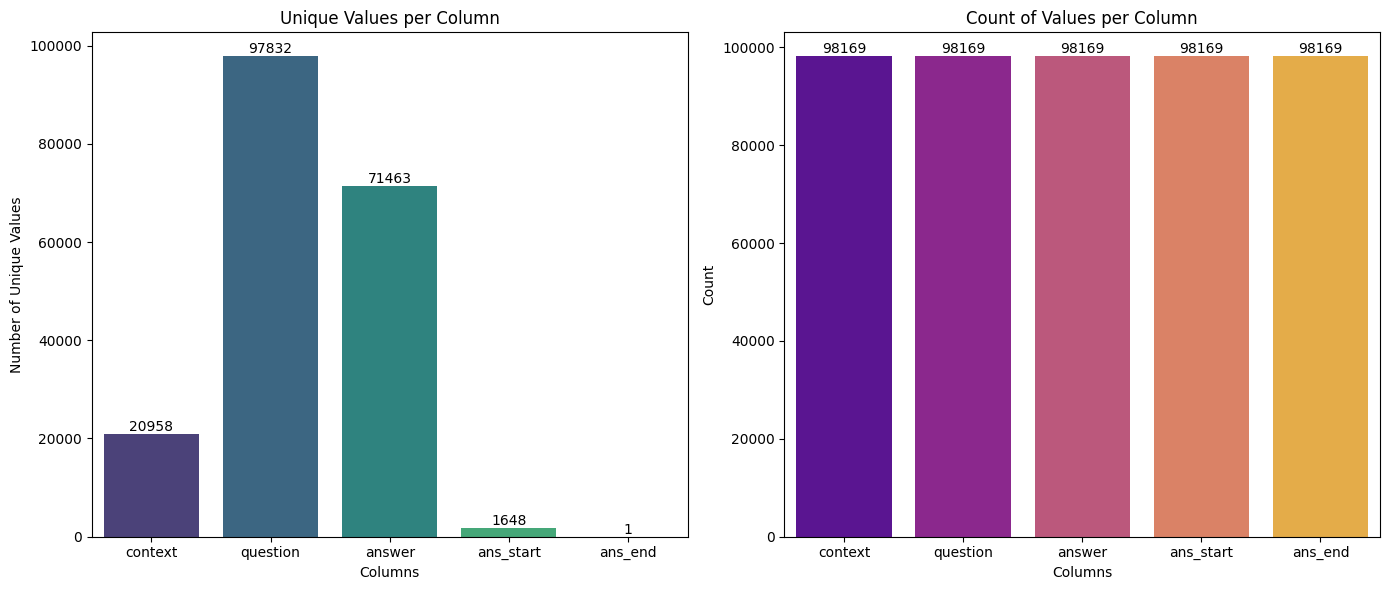

In [36]:
# Calculate the number of unique values in each column
unique_values = {column: len(merged_squad_df[column].unique()) for column in merged_squad_df.columns}

# Prepare the figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the bar plot for unique values in each column (subplot 1)
sns.barplot(x=list(unique_values.keys()), y=list(unique_values.values()), ax=axes[0], palette="viridis")
axes[0].set_title('Unique Values per Column')
axes[0].set_ylabel('Number of Unique Values')
axes[0].set_xlabel('Columns')

# Adding the count labels on top of the bars for the first plot
for i, (column, count) in enumerate(unique_values.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting a different plot type (e.g., count plot for demonstration) (subplot 2)
count_data = merged_squad_df.melt()['variable'].value_counts()
sns.barplot(x=count_data.index, y=count_data.values, ax=axes[1], palette="plasma")
axes[1].set_title('Count of Values per Column')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Columns')

# Adding the count labels on top of the bars for the second plot
for i, count in enumerate(count_data.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

In [37]:
# Get a summary of descriptive statistics for the numerical columns of the dataframe
merged_squad_df.describe().T

count        mean        std  min    25%    50%    75%     max
ans_start  98169.0  320.756777  268.44539  0.0  111.0  262.0  469.0  3126.0
ans_end    98169.0    0.000000    0.00000  0.0    0.0    0.0    0.0     0.0

In [42]:
# Examine the datatypes of each column
merged_squad_df.dtypes

context      object
question     object
answer       object
ans_start     int64
ans_end       int64
dtype: object

## Visualize duplicated rows using a Sunburst

In [103]:
import plotly.express as px

# Check if there are duplicate rows
pd.set_option('display.max_colwidth', None)
duplicate_rows = merged_squad_df[merged_squad_df.duplicated()]

if not duplicate_rows.empty:
    # Create a sunburst plot with increased size and tight layout
    fig = px.sunburst(
        duplicate_rows,
        path=duplicate_rows.columns.tolist(),
        title='Sunburst Chart of Duplicate Rows',
        width=3500,
        height=3000
    )

    # Update layout for a tight fit
    fig.update_layout(
        margin=dict(l=20, r=20, t=40, b=20),  # Adjust margins
        title_x=0.5,  # Center the title
        uniformtext=dict(minsize=10, mode='hide')  # Adjust text to avoid overlap
    )

    # Save the figure as an HTML file
    fig.write_html("sunburst_chart.html")

    # Download the saved HTML file
    from google.colab import files
    files.download('sunburst_chart.html')

    print("Sunburst chart saved as 'sunburst_chart.html'. Please open that file to review")
else:
    print("No duplicate rows found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sunburst chart saved as 'sunburst_chart.html'. Please open that file to review


- I noticed that there are 134 duplicated rows in the dataset.
- Here, I have not taken any action because this is just for pre-processing.
- I have taken care of the required steps in the corresponding training approaches.

In [41]:
# Check for duplicate rows.
pd.set_option('display.max_colwidth', None)
duplicate_rows = merged_squad_df[merged_squad_df.duplicated()]
duplicate_rows

context  \
529                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          on january 7, 2012, beyoncé gave birth to her first child, a daughter, blue ivy carter, at lenox hill hospital in new york. five months later, she performed for four nights at revel atlantic city's ovation hall to celebrate the resort's opening, her first performances since giving birth to blue ivy.   
1650                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              in 1827, soon after the death of chopin's youngest sister emilia, the family moved from the warsaw university building, adjacent to the kazimierz palace, to lodgings just across the street from the university, in the south annex of the krasiński palace on krakowskie przedmieście,[n 5] where chopin lived until he left warsaw in 1830.[n 6] here his parents continued running their boarding house for male students; the chopin family parlour (salonik chopinów) became a museum in the 20th century. in 1829 the artist ambroży mieroszewski executed a set of portraits of chopin family members, including the first known portrait of the composer.[n 7]   
1794   although the two displayed great respect and admiration for each other, their friendship was uneasy and had some qualities of a love-hate relationship. harold c. schonberg believes that chopin displayed a "tinge of jealousy and spite" towards liszt's virtuosity on the piano, and others have also argued that he had become enchanted with liszt's theatricality, showmanship and success. liszt was the dedicatee of chopin's op. 10 études, and his performance of them prompted the composer to write to hiller, "i should like to rob him of the way he plays my studies." however, chopin expressed annoyance in 1843 when liszt performed one of his nocturnes with the addition of numerous intricate embellishments, at which chopin remarked that he should play the music as written or not play it at all, forcing an apology. most biographers of chopin state that after this the two had little to do with each other, although in his letters dated as late as 1848 he still referred to him as "my friend liszt". some commentators point to events in the two men's romantic lives which led to a rift between them; there are claims that liszt had displayed jealousy of his mistress marie d'agoult's obsession with chopin, while others believe that chopin had become concerned about liszt's growing relationship with george sand.   
2019          

## Visualize the missing values in a bar plot

Here, I noticed that there are no missing values at all in the dataset. Hence, the plot looks empty.

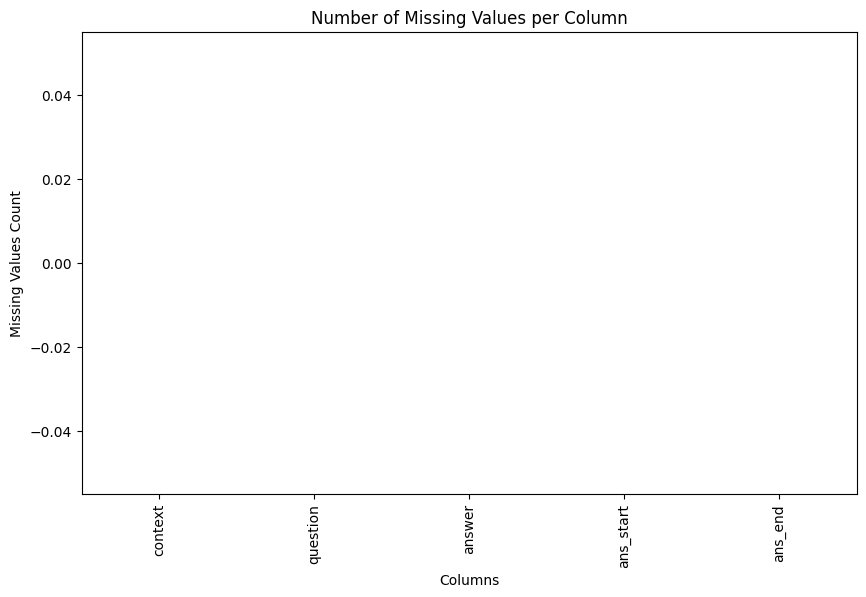

In [45]:
# Visualize the total number of missing values per column
missing_counts = merged_squad_df.isnull().sum()

plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.show()

In [29]:
# Check for missing values in each column
merged_squad_df.isnull().sum()

context      0
question     0
answer       0
ans_start    0
ans_end      0
dtype: int64

# Text data pre-processing

## Selection of the text data column from the dataframe

### Guidelines to select the text data column in case of multiple text data columns in the dataframe.

In general, let us say there is a CSV file containing the dataset and it has multiple columns. But only one column of it has text content. If we need to perform any task related to the text content, we can easily do it.

But sometimes, there are datasets where there are multiple columns having text content in all of them.

During this scenario, it is our utmost responsibility to select the correct column (containing text data) of the dataset. Let me simply explain how to select the column to preprocess and do further analysis.

- **Relevance to the Task:** Choose the column most pertinent to your analysis or machine/deep learning task.

- **Content Quality:** Assess the quality of the text. Look for columns that have fewer missing values, less noise, or more coherent language.

- **Length and Structure:** Consider the average length of the text and whether the format is consistent. Short, structured text (like titles) might be more appropriate for certain analyses compared to long, free-form text.

- **Diversity:** If the task requires varied inputs, choose columns that provide a range of perspectives or types of information.

- **Data Volume:** Analyze the size of the text in each column. Columns with more substantial data might provide better insights for modeling.

- **Feature Extraction Potential:** Evaluate the potential for extracting useful features (like keywords or entities) from the text.

Apply the above guidelines to select the text data column in case of multiple text data columns in the dataframe.

Now, let us make use of the above guidelines and decide the column containing the text data to preprocess further from the merged SQuAD Dataframe.

Compare these columns with the above guidelines.

- **Relevance to the Task:** Our task is to perform preprocessing. all the `context`, `question` and `answer` columns have text data.

- **Content Quality:** `context`, `question` and `answer`  are inter-related to each other. All these columns do not have any null or missing values.

- **Length and Structure:** The average length of the text and consistent format is available in `context`, `question` and `answer` columns. Though the `answer` column has very less data, but it still has some noise. Hence, we need to clean that.

- **Diversity:** Various ranges and types of information is available in the `context`, `question` and `answer` columns.

- **Data Volume:** `context`, `question` and `answer` columns have the substantial data that provides diverse range of information.

- **Feature Extraction Potential:** The potential for extracting useful features (like keywords or entities) from the text is mostly available in `context`, `question` and `answer` columns.

## Load the SQuAD dataframe into your Python environment and preprocess the data as needed (e.g., remove unnecessary characters, tokenize, etc.).

To perform text preprocessing, we need only the claim column. Hence, as `context`, `question` and `answer` columns are interconnected, I have taken them into a new dataframe. Then I passed them to the text preprocessing.

Look at the following code and results.

In [60]:
# Create a new dataframe with just "context", "question" and "answer" columns

data = merged_squad_df[["context", "question", "answer"]]

pd.set_option('display.max_colwidth', None)

data.head(10)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto 

To preprocess any text data, we have many steps to follow. As part of this assignment, I followed the below preprocessing steps:

**Removal of HTML tags:** Strips HTML tags, if any (e.g., `<div>`, `<p>`) from text, leaving only the content. This is essential for cleaning web-scraped data or text extracted from HTML documents. It helps ensure that only the meaningful text is processed. It also removes unwanted scrap from the data to make it more readable.

**Removal of URLs:** Eliminates web addresses (e.g., http://example.com) from the text. URLs are often irrelevant to text analysis and they might add noise. Removing them helps in focusing on the actual content of the text.

**Removal of Email IDs:** Deletes email addresses (e.g., `user@example.com`) from the text. Email IDs are typically not useful for analysis and can be considered noise, so removing them cleans the text for more accurate processing. Having more noise in the data yields poor results. Hence, it is better to torture the data as much as possible until we obtain positive results.

**Convert to Lowercase:** This was already taken care before itself.

**Replace contractions with simple strings:** This involves expanding shortened forms of words into their full, standard expressions. Contractions are often used in casual or spoken English to create a more informal tone, but in more formal writing or for certain types of text analysis, it's sometimes necessary to convert these contractions back to their complete forms.

Examples of contractions:
```
"can't" -> "cannot"
"don't" -> "do not"
"it's" -> "it is"
"you're" -> "you are"
"she's" -> "she is"
"he's" -> "he is"
```

**Removal of Punctuations:** Removes punctuation marks (e.g., .,!?) from the text. Punctuation can often be extraneous for text processing tasks, so removing it helps in simplifying the text and focusing on the words themselves.

**Perform Tokenization:** Tokenization is a fundamental process of NLP where the text data is split into smaller and manageable units called Tokens. The token could be anything such as words, phrases, symbols etc.

**Lemmatization and Stopwords Removal:**

***Lemmatization*** reduces words to their base or dictionary form (lemma) using vocabulary and morphological analysis. It is more precise and results in actual words.
***Stopwords Removal*** is the process of filtering out the common words that are often considered irrelevant for analysis. These words are known as "stop words," and they typically include articles, prepositions, conjunctions, and other common terms that do not carry significant meaning in the context of analysis. Examples include words like "the," "and," "is," "in," and "on.".
Small note for Lemmatization and Stopwords Removal:

`doc = nlp(text)` line in the below code as part of this step is nothing but the loaded SpaCy NLP model. When we pass the clean text to this, it will by default performs tokenization.
Lemmatization and Stopwords removal happen only after tokenization.
Here I have loaded the common SpaCy English Large sized model and performed almost all the preprocessing steps using SpaCy.

In [65]:
# Download and load SpaCy English Large model
nlp = spacy.load("en_core_web_lg")

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove Email IDs
    # Define the regex pattern for matching email addresses
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    # Substitute email addresses with an empty string
    text = re.sub(email_pattern, '', text)

    # Replace contractions with simple strings
    # Initial dictionary of common contractions
    contractions_dict = {
      "ain't": "am not",
      "aren't": "are not",
      "can't": "cannot",
      "couldn't": "could not",
      "didn't": "did not",
      "doesn't": "does not",
      "don't": "do not",
      "hadn't": "had not",
      "hasn't": "has not",
      "haven't": "have not",
      "he's": "he is",
      "how's": "how is",
      "I'm": "I am",
      "I've": "I have",
      "isn't": "is not",
      "it'll": "it will",
      "it's": "it is",
      "let's": "let us",
      "mightn't": "might not",
      "mustn't": "must not",
      "shan't": "shall not",
      "she's": "she is",
      "shouldn't": "should not",
      "wasn't": "was not",
      "we're": "we are",
      "weren't": "were not",
      "what's": "what is",
      "where's": "where is",
      "who's": "who is",
      "won't": "will not",
      "wouldn't": "would not",
      "gonna": "going to",
      "wanna": "want to"
    }

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in contractions_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: contractions_dict[x.group()], text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Lemmatize and remove stopwords
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

In [66]:
# List of columns to apply the function to
columns_to_preprocess = ['context', 'question', 'answer']

# Apply the preprocessing function to each specified column
data[columns_to_preprocess] = data[columns_to_preprocess].applymap(preprocess_text)

# Display the first 10 rows of the updated DataFrame
data.head(10)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
4                                                                                                                                                                                                                                                            

- Almost all the text preprocessing is already done above. But tokenization was not done.

- We have to perform tokenization at the starting point itself but we have already used doc = `nlp(text)` in the above code cell.

- Hence, for lemmatization and stop words removal, the NLP loaded model itself has taken care of tokenization.
Now, we have to explicitly perform tokenization to all the `context`, `question` and `answer` columns post preprocessing.

***One of my learnings is:*** If we perform tokenization post text-preprocessing, the text looks clean after tokenization. Else, there might be a chance of noise inside the text, how much ever we take care.

- Look at the following code for the same. I have saved the tokens in separate columns `tokenized_context`, `tokenized_question` and `tokenized_answer` instead of distrubing the existing preprocessed claim.

In [67]:
# List of columns to tokenize
columns_to_tokenize = ['context', 'question', 'answer']

# Perform tokenization and create new columns for the tokenized results
for column in columns_to_tokenize:
    data[f'tokenized_{column}'] = data.apply(lambda row: nltk.word_tokenize(row[column]), axis=1)

# Display the first 10 rows of the updated DataFrame
data.head(10)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
4                                                                                                                                                                                                                                                            

# Apply NER techniques to identify named entities (such as persons, organizations, locations, etc.) within the text. Post that, implement POS tagging to assign appropriate parts of speech to different words in the text.

I have defined a `get_pos_and_ner` function that performs two tasks:

- Part-of-Speech (POS) tagging
- Named Entity Recognition (NER).

Here, the way you're processing NER is slightly different from how POS tags are generated

I mean:

- We are initially tokenizing every sentence.
- We are applying Part-of-Speech (POS) tagging to the generated list of tokens.
- We are creating a tree structure of named entities based on the POS tags.
- We are converting the created tree into a format where it includes particular word, its corresponding POS tag followed by Named Entity tag.

Look at the code below for the same.

In [68]:
# Function to get POS tags and named entities
def get_pos_and_ner(sentence):
    # Tokenize the sentence
    words = word_tokenize(sentence)
    # Apply POS tagging to the list of tokens, resulting in tuples of (word, POS tag).
    pos_tags = pos_tag(words)

    # Create a tree structure of named entities based on the POS tags.
    named_entities_tree = ne_chunk(pos_tags)

    # Convert the tree into a format that includes the word, POS tag, and a named entity tag
    named_entities = tree2conlltags(named_entities_tree)

    return pos_tags, named_entities

# Call the defined function to perform POS
data['context_POS'] = data['context'].apply(lambda x: get_pos_and_ner(x)[0])
data['question_POS'] = data['question'].apply(lambda x: get_pos_and_ner(x)[0])
data['answer_POS'] = data['answer'].apply(lambda x: get_pos_and_ner(x)[0])


data['context_NER'] = data['context'].apply(lambda x: get_pos_and_ner(x)[1])
data['question_NER'] = data['question'].apply(lambda x: get_pos_and_ner(x)[1])
data['answer_NER'] = data['answer'].apply(lambda x: get_pos_and_ner(x)[1])

# Display the results
data.head(30)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue mary   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           architecturally school catholic character atop main building gold dome golden statue virgin mary immediately main building face copper statue christ arm upraise legend venite ad omnes main building basilica sacred heart immediately basilica grotto marian place prayer reflection replica grotto lourdes france virgin mary reputedly appear saint bernadette soubirous 1858 end main drive direct line connect 3 statue gold dome simple modern stone statue m

## How to recognize the POS and NER tags from the results obtained above?

If you look at the first 10 rows of the results printed above after POS tagging and NER, the tags are printed in terms of acronyms. Look at the below table to recognize those tags in human understandable manner.

**POS Tags:**

| Tag  | Description                                |
|------|--------------------------------------------|
| CC   | Coordinating conjunction                    |
| CD   | Cardinal number                             |
| DT   | Determiner                                  |
| EX   | Existential there                           |
| FW   | Foreign word                                |
| IN   | Preposition or subordinating conjunction    |
| JJ   | Adjective                                   |
| JJR  | Adjective, comparative                      |
| JJS  | Adjective, superlative                     |
| LS   | List item marker                           |
| MD   | Modal verb                                  |
| NN   | Noun, singular or mass                     |
| NNS  | Noun, plural                               |
| NNP  | Proper noun, singular                       |
| NNPS | Proper noun, plural                         |
| PDT  | Predeterminer                              |
| POS  | Possessive ending                           |
| PRP  | Personal pronoun                            |
| `PRP$` | Possessive pronoun                          |
| RB   | Adverb                                     |
| RBR  | Adverb, comparative                         |
| RBS  | Adverb, superlative                        |
| RP   | Particle                                    |
| TO   | "to" as a preposition or infinitive marker |
| UH   | Interjection                                |
| VB   | Verb, base form                            |
| VBD  | Verb, past tense                            |
| VBG  | Verb, gerund or present participle         |
| VBN  | Verb, past participle                       |
| VBP  | Verb, non-3rd person singular present      |
| VBZ  | Verb, 3rd person singular present          |
| WDT  | Wh-determiner                              |
| WP   | Wh-pronoun                                 |
| `WP$`  | Possessive wh-pronoun                      |
| WRB  | Wh-adverb                                  |

**NER Tags:**

| Tag      | Description                                   |
|----------|-----------------------------------------------|
| O        | Other (not a named entity)                    |
| B-PER    | Beginning of a person's name                  |
| I-PER    | Inside a person's name                        |
| B-ORG    | Beginning of an organization                   |
| I-ORG    | Inside an organization name                    |
| B-LOC    | Beginning of a location                        |
| I-LOC    | Inside a location name                         |
| B-MISC   | Beginning of a miscellaneous entity            |
| I-MISC   | Inside a miscellaneous entity name             |
| B-DATE   | Beginning of a date expression                 |
| I-DATE   | Inside a date expression                       |
| B-TIME   | Beginning of a time expression                 |
| I-TIME   | Inside a time expression                       |
| B-MONEY  | Beginning of a monetary value                  |
| I-MONEY  | Inside a monetary value                        |
| B-PERCENT| Beginning of a percentage expression           |
| I-PERCENT| Inside a percentage expression                 |
| B-QUANTITY| Beginning of a quantity expression            |
| I-QUANTITY| Inside a quantity expression                  |
| B-ART    | Beginning of a work of art (e.g., books, movies) |
| I-ART    | Inside a work of art                          |
| B-LANGUAGE| Beginning of a language name                  |
| I-LANGUAGE| Inside a language name                        |
| B-DEVICE | Beginning of a device name                    |
| I-DEVICE | Inside a device name                          |
| DATE | Specific dates or periods of time                        |
| CARDINAL | Numerical values indicating quantity                          |
| GPE | Countries, cities, and states                          |
| QUANTITY | Specific quantities, often related to measurements                          |
| ORG | Companies, agencies, institutions, and organizations                          |
| FAC | Buildings, airports, highways, bridges, and structures                          |
| NORP | Nationalities, ethnic groups, and religious/political affiliations                          |


# Analyze the results and provide insights on the named entities and their corresponding parts of speech obtained from the SQuAD's cleaned dataset

## Visualization of obtained Named Entities Results

- If you look at the above resultant table, we can see the POS and NER tags tagged to each token which is fine.

- But, the visualization is not properly understandable.

- Hence, the `spacy` library provides a visualizer tool named `displacy` which will help in displaying and understanding NLP results, such as dependency parses and named entities. It's designed to help users easily visualize the linguistic annotations generated by SpaCy's models.

If you use displacy tool and visualize the Named Entities, it highlights named entities within text, categorizing them into types (like ***PERSON***, ***ORGANIZATION***, ***LOCATION***, etc.) and providing an intuitive visual representation. This helps in quickly identifying and understanding the entities present in the text.

Look at the below code how `displacy` renders the tokens along with their Named Entities in Jupyter notebook.

If you see the below result, all the Named Entities are displayed in color-coded format for better understanding purpose.

### Visulaize the Named Entities Results of `context`

In [76]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    context = data['context'].iloc[index]  # Access the row value correctly
    # Ensure context is a string
    if isinstance(context, str):
        # Process the text with SpaCy
        doc = nlp(context)
        # Render in Jupyter
        displacy.render(doc, style='ent', jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

### Visulaize the Named Entities Results of `question`

In [77]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    question = data['question'].iloc[index]  # Access the row value correctly
    # Ensure question is a string
    if isinstance(question, str):
        # Process the text with SpaCy
        doc = nlp(question)
        # Render in Jupyter
        displacy.render(doc, style='ent', jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

### Visulaize the Named Entities Results of `answer`

In [78]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    answer = data['answer'].iloc[index]  # Access the row value correctly
    # Ensure answer is a string
    if isinstance(answer, str):
        # Process the text with SpaCy
        doc = nlp(answer)
        # Render in Jupyter
        displacy.render(doc, style='ent', jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

# Visualization of obtained POS and NER Results using Dependency Parsing

- When you use the `displacy` tool to visualize dependency parsing, it provides a clear representation of the grammatical structure of a sentence.

- Each word in the sentence is displayed along with arrows that indicate how the words are connected to each other based on their grammatical relationships. This visualization helps in understanding the syntactic dependencies between words, making it easier to analyze sentence structure.

- Dependency parsing analyzes the grammatical structure of a sentence to establish relationships between words, showing how they depend on one another.

Here are the steps of Understanding the Visualization:

In a dependency parse tree, each word is a node, and the edges (connections) indicate the relationships. Here is how to interpret it:

- **Roots:** Typically, the main verb of the sentence is the root of the tree.

- **Branches:** Each word connected to the root or other words represents a specific grammatical relationship (using the labels above).

- **Hierarchy:** The structure shows which words are dependent on others, giving insight into the sentence’s grammatical structure.

**Output:** The result is a tree structure or graph that represents the dependencies among words, along with labels indicating the type of relationship (like nsubj, dobj, amod).

If you see the below output, you will notice some dependency labels. Here is the explanation of them.

| Dependency Label | Full Form              | Meaning                                                                                     |
|------------------|------------------------|---------------------------------------------------------------------------------------------|
| nsubj            | Nominal Subject        | The noun phrase that acts as the subject of a verb.                                        |
| nmod             | Noun Modifier          | A noun that modifies another noun.                                                          |
| amod             | Adjectival Modifier    | An adjective that modifies a noun.                                                         |
| advmod           | Adverbial Modifier     | An adverb that modifies a verb, adjective, or another adverb.                             |
| compound         | Compound Modifier      | A word that modifies another word and is part of a multi-word expression (e.g., "toothbrush"). |
| dep              | Dependent              | A generic label for dependencies that do not fit other categories.                         |
| advcl            | Adverbial Clause       | A dependent clause that acts as an adverb.                                                |
| dobj             | Direct Object          | The noun phrase that receives the action of a transitive verb.                             |
| conj             | Conjunction            | A word that connects clauses or sentences (e.g., "and", "but").                          |
| ROOT             | Root                   | The main verb or the root of the syntactic structure.                                      |
| punct            | Punctuation            | Marks such as commas, periods, or other punctuation in the sentence.                       |
| ccomp            | Clausal Complement     | A clause that acts as a complement to a verb.                                             |
| xcomp            | Open Clausal Complement | A dependent clause that is a complement of a verb but has its own subject.                 |


## Prepare and visualize Dependency Parsing for `context` column

In [80]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    context = data['context'].iloc[index]  # Access the row value correctly
    # Ensure context is a string
    if isinstance(context, str):
        # Process the text with SpaCy
        doc = nlp(context)

        options = {
            "bg": "#E1F5FE",
            "color": "#2E7D32",
            "width": 600
        }

        # Render in Jupyter
        displacy.render(doc, style='dep', options=options, jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

## Prepare and visualize Dependency Parsing for `question` column

In [82]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    question = data['question'].iloc[index]  # Access the row value correctly
    # Ensure question is a string
    if isinstance(question, str):
        # Process the text with SpaCy
        doc = nlp(question)

        options = {
            "bg": "#E1F5FE",
            "color": "#2E7D32",
            "width": 600
        }

        # Render in Jupyter
        displacy.render(doc, style='dep', options=options, jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

## Prepare and visualize Dependency Parsing for `answer` column

In [81]:
# Process and visualize Named Entities for the first 30 rows
for index in range(0, 30):  # For the first 30 rows
    answer = data['answer'].iloc[index]  # Access the row value correctly
    # Ensure answer is a string
    if isinstance(answer, str):
        # Process the text with SpaCy
        doc = nlp(answer)

        options = {
            "bg": "#E1F5FE",
            "color": "#2E7D32",
            "width": 600
        }

        # Render in Jupyter
        displacy.render(doc, style='dep', options=options, jupyter=True)
    else:
        print(f"Row {index} does not contain a valid string for NER processing.")

# Visualize the findings using appropriate graphs, charts, or tables to enhance understanding.

To visualize the differences between the original text  and the preprocessed text of the following, we can use several approaches. The goal of these visualizations is to understand how the preprocessing steps have transformed your text data.

*   `merged_squad_df['context']` and `data['context']`
*   `merged_squad_df['question']` and `data['question']`
*   `merged_squad_df['answer']` and `data['answer']`

Here are a few types of visualizations that might be useful:



## Word Cloud

- In general, Word cloud is a visual representation of text data where the size of each word indicates its frequency or importance within the dataset.
- This makes it a useful tool for quickly identifying the most prominent themes or terms in a given text, helping to summarize and analyze large volumes of information at a glance.

### Word Cloud of `context` column (before preprocessing) and `context` column (after preprocessing).

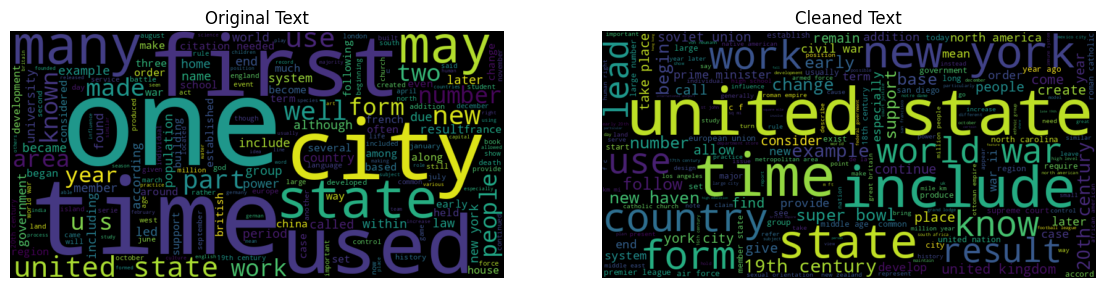

In [83]:
# Generate word cloud for original text
text_original = ' '.join(merged_squad_df['context'].astype(str))
wordcloud_original = WordCloud(width=800, height=400, background_color='black').generate(text_original)

# Generate word cloud for cleaned text
text_cleaned = ' '.join(data['context'].astype(str))
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='black').generate(text_cleaned)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Original Text')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.title('Cleaned Text')
plt.axis('off')

plt.show()

### Word Cloud of `question` column (before preprocessing) and `question` column (after preprocessing).

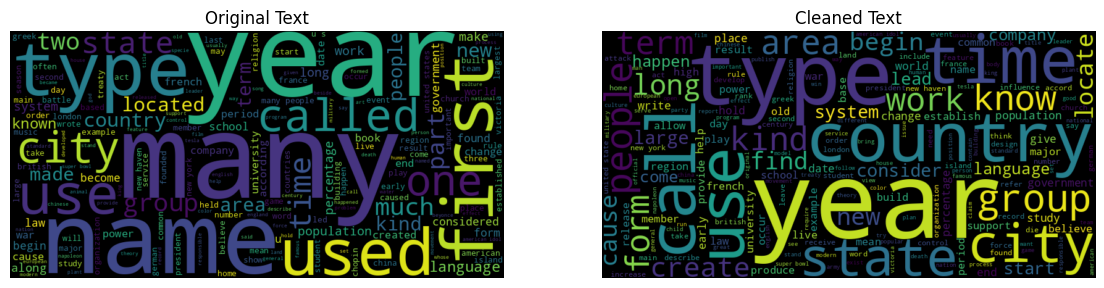

In [69]:
# Generate word cloud for original text
text_original = ' '.join(merged_squad_df['question'].astype(str))
wordcloud_original = WordCloud(width=800, height=400, background_color='black').generate(text_original)

# Generate word cloud for cleaned text
text_cleaned = ' '.join(data['question'].astype(str))
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='black').generate(text_cleaned)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Original Text')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.title('Cleaned Text')
plt.axis('off')

plt.show()

### Word Cloud of `answer` column (before preprocessing) and `answer` column (after preprocessing).

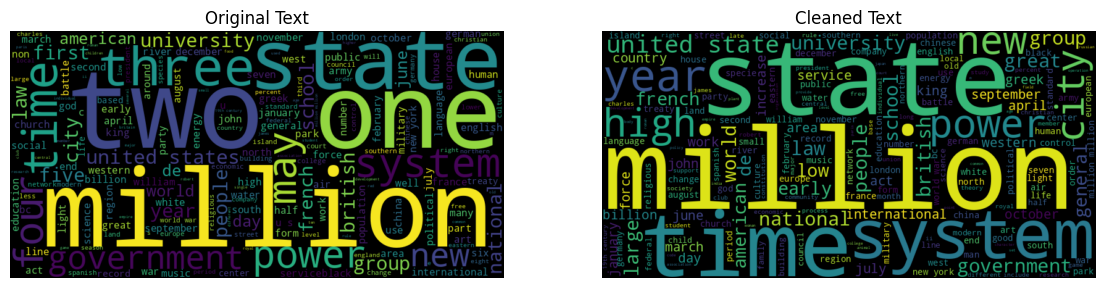

In [84]:
# Generate word cloud for original text
text_original = ' '.join(merged_squad_df['answer'].astype(str))
wordcloud_original = WordCloud(width=800, height=400, background_color='black').generate(text_original)

# Generate word cloud for cleaned text
text_cleaned = ' '.join(data['answer'].astype(str))
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='black').generate(text_cleaned)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Original Text')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.title('Cleaned Text')
plt.axis('off')

plt.show()

## Top 50 words of the preprocessed text data

### Look at the below code to figure out the top 50 words from the `data['context']` after preprocessing the text data.

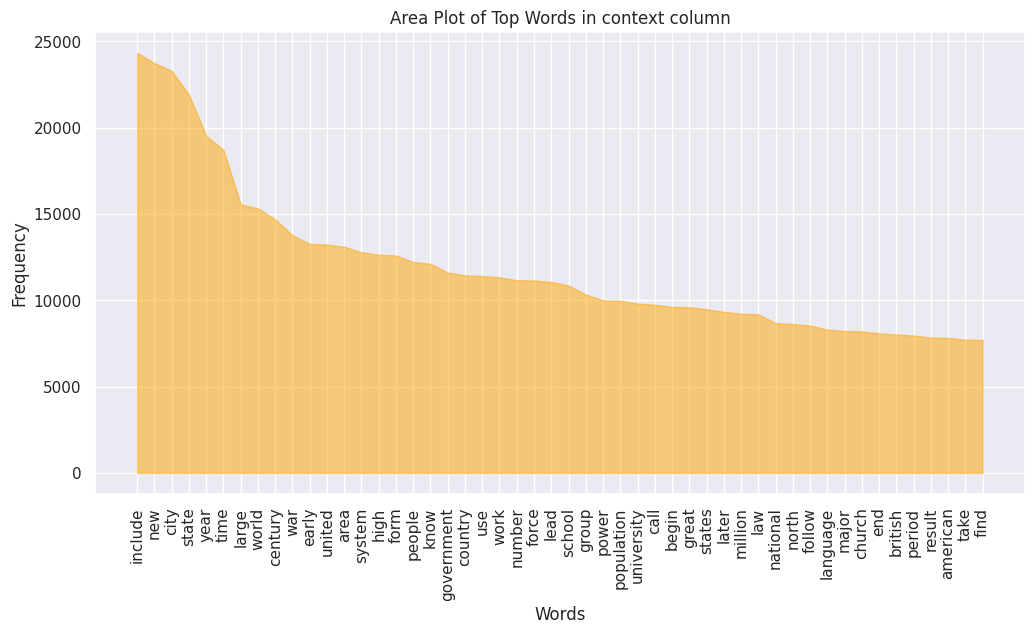

In [86]:
# Combine all text into a single string
all_text = ' '.join(data['context'])

# Create a TextBlob object
blob = TextBlob(all_text)

# Get the words (list of words in the TextBlob)
words = blob.words

# Count the words
word_counts = Counter(words)

# Get the top 50 words
top_words = word_counts.most_common(50)
words, counts = zip(*top_words)

# Plot the Area plot
plt.figure(figsize=(12, 6))
plt.fill_between(words, counts, color='orange', alpha=0.5)
plt.title('Area Plot of Top Words in context column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Look at the below code to figure out the top 50 words from the `data['question']` after preprocessing the text data.

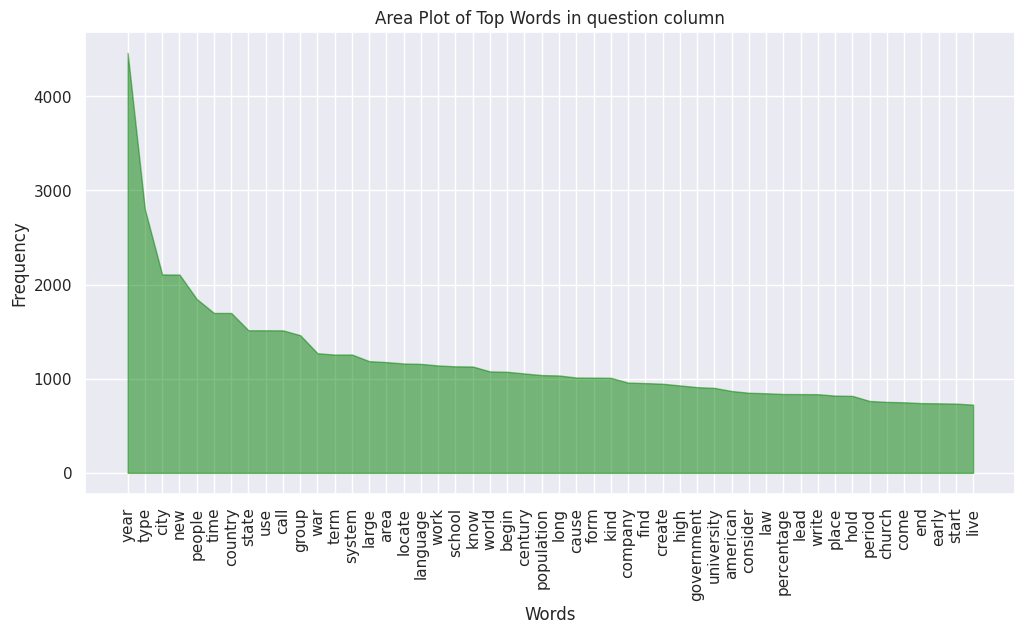

In [90]:
# Combine all text into a single string
all_text = ' '.join(data['question'])

# Create a TextBlob object
blob = TextBlob(all_text)

# Get the words (list of words in the TextBlob)
words = blob.words

# Count the words
word_counts = Counter(words)

# Get the top 50 words
top_words = word_counts.most_common(50)
words, counts = zip(*top_words)

# Plot the Area plot
plt.figure(figsize=(12, 6))
plt.fill_between(words, counts, color='green', alpha=0.5)
plt.title('Area Plot of Top Words in question column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Look at the below code to figure out the top 50 words from the `data['answer']` after preprocessing the text data.

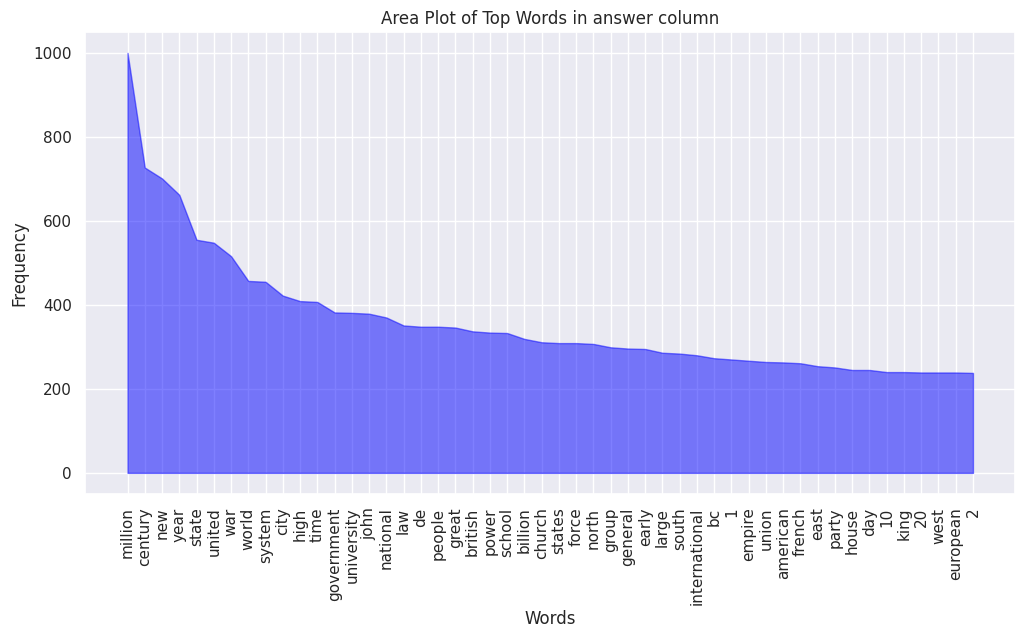

In [88]:
# Combine all text into a single string
all_text = ' '.join(data['answer'])

# Create a TextBlob object
blob = TextBlob(all_text)

# Get the words (list of words in the TextBlob)
words = blob.words

# Count the words
word_counts = Counter(words)

# Get the top 50 words
top_words = word_counts.most_common(50)
words, counts = zip(*top_words)

# Plot the Area plot
plt.figure(figsize=(12, 6))
plt.fill_between(words, counts, color='blue', alpha=0.5)
plt.title('Area Plot of Top Words in answer column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Save the processed dataframe

In [89]:
data.to_csv("squad_processed.csv", index=False)

# Final Report, Summary, Findings/Observations, Additional insights, Challenges and Conclusion

## Observations/Conclusions from the section "*Exploration and Visualization of SQuAD dataset*"

- No missing values in the dataset.
- Noticed duplicated rows but haven't actioned on them because this is just preprocessing alone. I have handled the project level preprocessing in [this file](https://github.com/kraviteja95usd/smartchat-conversational-chatbot/blob/chatbot-by-ravi/SQuAD_using_bert-base-uncased/SQuAD_using_bert-base-uncased_training_and_validation.ipynb).

## Observations/Conclusions from the section "*Explore and Understand the data*"

I have initially downloaded and loaded `en_core_web_lg` model. It has more number of parameters and these are actually sufficient for NER and POS. This can handle heavy number of records in the dataset.

All the text preprocessing was performed using SpaCy library.

**Justification:** While NLTK is highly flexible and offers a wide range of tools for text analysis and education, it can require more boilerplate code and manual steps for preprocessing tasks. SpaCy, on the other hand, is streamlined for practical applications, making it a favorite for many developers and researchers looking for efficiency and ease of use in text preprocessing.

As part of text preprocessing, we have the followed the below order:

- Removed HTML tags
- Removed URLs
- Removed Email IDs
- Converted to lowercase
- Replaced contractions with simple strings
- Removed punctuations
- Lemmatized and removed stopwords

*Note:* I could have tokenized the text at first place itself. But because of the above mentioned HTML tags, URLs, email IDs etc, there is a high chance that noise is present and then it will also be tokenized. Hence, tokenization was performed after all the above points.

## Observations/Conclusions from the section "*Apply NER techniques to identify named entities (such as persons, organizations, locations, etc.) within the text. Post that, implement POS tagging to assign appropriate parts of speech to different words in the text.*"

- When I performed NER and POS and looked at the first 30 results in tabular format, I noticed they got tagged properly.

As part of "*Visualization of obtained Named Entities Results*" section, very few sentences have not recognized Named Entities.

However, this model has recognized almost most of the sentences properly.

This recognition is actually done to understand the relation, context etc between each each word of the sentence.

## Observations/Conclusions from the section "*Visualize the findings using appropriate graphs, charts, or tables to enhance understanding*"

- I have plotted the word clouds for both raw and preprocessed texts for all the the following columns separately. This way, I have understood that most repeated words are displayed in larger size followed by the least repeated words displayed in smaller size.
  - context
  - question
  - answer

- I have also plotted the frequecies of POS tags of each sentence.

- Finally, I have also plotted the top 50 words of the prepreocessed text using an Area plot.